<center><h1><font size="7">Classification automatiques de commentaires</font></h1></center>


# Sommaire

* [Partie I :  Sélection et nettoyage des données](#partie1)
* [Partie II : Analyses](#partie2)
    * [2.1 Premier modèle, première prédictions](#partie2_1)
    * [2.2 Word Embedding - modèles classiques](#partie2_2)
        * [2.2.1- Word2Vec](#partie2_2_1)
        * [2.2.2- Doc2Vec](#partie2_2_2)
        * [2.2.1- FastText](#partie2_2_3)
    * [2.3 Modèle BERT](#partie2_3)


# Partie I :  Sélection et nettoyage des données <a class="anchor" id="partie1"></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import os 
import contractions
import matplotlib.pyplot as plt
from textblob import TextBlob

In [ ]:
cwd = os.getcwd()

In [ ]:
os.listdir()

['.ipynb_checkpoints',
 'bad_buzz_clean.csv',
 'CoCl',
 'P7_commentaires_prediction_buzz_01-Copy1.ipynb',
 'P7_commentaires_prediction_buzz_01.ipynb',
 'P7_dev',
 'sentiment140.zip',
 'training.1600000.processed.noemoticon.csv']

In [ ]:
fichier = "{}\\training.1600000.processed.noemoticon.csv".format(cwd) 

In [ ]:
i = 1
with pd.read_csv(
    fichier, sep=',',
    names=["target", 'ids', 'date', 'flag', 'user','text'], 
    chunksize=100000, on_bad_lines='skip',
    nrows=1600000, encoding_errors='ignore', encoding="ISO-8859-1") as reader_review:
    for chunck in reader_review:
        locals()['data_bad_buzz_' + str(i)] = chunck
        i += 1

print("Le document a été ouvert en {} fois".format(i))

Le document a été ouvert en 17 fois


Nos datas contiennent la colonne target ayant 3 valeurs possibles indiquant la teneur du commentaire :

 - 0 : négatif
 - 4 : positif
 

In [ ]:
# On séléctionne maintenant n=10 000 datas par target pour le train puis pour le test
n = 10000
bad_buzz_train_0 = data_bad_buzz_1.loc[data_bad_buzz_1.target == 0, ["target", "text"]].iloc[:n]
bad_buzz_train_4 = data_bad_buzz_12.loc[data_bad_buzz_12.target == 4, ["target", "text"]].iloc[:n]

bad_buzz_test_0 = data_bad_buzz_2.loc[data_bad_buzz_2.target == 0, ["target", "text"]].iloc[:n]
bad_buzz_test_4 = data_bad_buzz_13.loc[data_bad_buzz_13.target == 4, ["target", "text"]].iloc[:n]

In [ ]:
bad_buzz_test_4

,target,text
1200000,4,danielle is the best thing since cheese in a c...
1200001,4,@roxyreeb You need a new hobby. Wanna train fo...
1200002,4,"loooves my friends, and as of today loves the ..."
1200003,4,the hills last one D:
1200004,4,teamviewer is entertaining
...,...,...
1209995,4,can't sleep too excited!! up decorating my bab...
1209996,4,@addie_c haha I wonder what they're gonna play...
1209997,4,@theBrandiCyrus just because you arent a milli...
1209998,4,"Will watch tv first. Hmmm, I guess I'm wishin..."


In [ ]:
bad_buzz_train = pd.concat([bad_buzz_train_0, bad_buzz_train_4], axis='index', ignore_index=True)
bad_buzz_test = pd.concat([bad_buzz_test_0, bad_buzz_test_4], axis='index', ignore_index=True)

bad_buzz = pd.concat([bad_buzz_train, bad_buzz_test], axis='index', ignore_index=True)

In [ ]:
bad_buzz

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
39995,4,can't sleep too excited!! up decorating my bab...
39996,4,@addie_c haha I wonder what they're gonna play...
39997,4,@theBrandiCyrus just because you arent a milli...
39998,4,"Will watch tv first. Hmmm, I guess I'm wishin..."


In [ ]:
# Abbréviations communes et emmoticones
from CoCl.constantes import sample_abbr, emoticons_dict


In [ ]:
import re

def clean_text(text):
    # On met tout en minuscules
    text = text.lower()
    
    # On supprime les formes contractés du texte pour uniformiser le format du texte avec la forme décontractée
    text = contractions.fix(text)
    
    # Remplacement des smiley par du texte
    text = " ".join([emoticons_dict.get(word, word) for word in text.split()])
    
    # Remplacement des abbréviations du texte
    text = " ".join([sample_abbr.get(word, word) for word in text.split()])
    
    # Remplacement de certaines parties du texte tels que les utilisateurs, les liens, les mentions
    text = re.sub(r'@\w+', 'AT_USER', text)
    text = re.sub(r'https?://\S+', 'URL', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub(r'[\s]+', ' ', text)
    text = re.sub(r'[^a-zA-Z_]', ' ', text)
    
    # Remplacement des suites de caractères répétées
    text = re.compile( r"(.)\1{2,}" ).sub( r"\1\1", text)
    
    # Correction des fautes d'orthographes
    text = ''.join(TextBlob(text).correct())
    
    return text

__Sequentiel__

In [ ]:
# %%time

# bad_buzz['text_clean'] = bad_buzz['text'].apply(clean_text)

CPU times: total: 18.3 s
Wall time: 18.3 s


__Parallèle__

In [ ]:
import multiprocessing as mp
from parallel_pandas import ParallelPandas

#initialize parallel-pandas
ParallelPandas.initialize(n_cpu=mp.cpu_count(), show_vmem=True, disable_pr_bar=False)

In [ ]:
%%time

bad_buzz['text_clean'] = bad_buzz['text'].p_apply(clean_text, executor='threads')

CLEAN_TEXT DONE:   0%|          | 0/40000 [00:00<?, ?it/s]

VMEM USAGE: 50.5%|#####     |  13.9G

CPU times: total: 2h 44min 3s
Wall time: 2h 44min 8s


In [ ]:
bad_buzz.text_clean

0        AT_USER URL  www  that is a summer  you should...
1        is upset that he cannot update his facebook by...
2        AT_USER i dived many times for the ball  manag...
3           my whole body feels itchy and like its on fire
4        AT_USER no  it is not behaving at all  i am ma...
                               ...                        
39995    cannot sleep too excited  up decorating my bab...
39996    AT_USER hata i wonder what they are going to p...
39997    AT_USER just because you are not a millionaire...
39998    will watch to first  him  i guess i am wishing...
39999    morning world  please excuse my rabble as i tr...
Name: text_clean, Length: 40000, dtype: object

In [ ]:
bad_buzz.to_csv("bad_buzz_clean.csv", sep="\t", index=False)

# Partie II : Analyses <a class="anchor" id="partie2"></a> 

In [ ]:
bad_buzz = pd.read_csv("bad_buzz_clean.csv", sep="\t")

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tokenise
bad_buzz['text_clean'] = bad_buzz['text_clean'].apply(word_tokenize)

# Lemmatise
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in text]

bad_buzz['text_clean'] = bad_buzz['text_clean'].apply(lemmatize_text)

In [ ]:
bad_buzz.text_clean

0        [AT_USER, URL, www, that, is, a, summer, you, ...
1        [is, upset, that, he, can, not, update, his, f...
2        [AT_USER, i, dived, many, time, for, the, ball...
3        [my, whole, body, feel, itchy, and, like, it, ...
4        [AT_USER, no, it, is, not, behaving, at, all, ...
                               ...                        
39995    [can, not, sleep, too, excited, up, decorating...
39996    [AT_USER, hata, i, wonder, what, they, are, go...
39997    [AT_USER, just, because, you, are, not, a, mil...
39998    [will, watch, to, first, him, i, guess, i, am,...
39999    [morning, world, please, excuse, my, rabble, a...
Name: text_clean, Length: 40000, dtype: object

In [ ]:
def frequence_mot(texte_serie):
    """
    avis_serie_n : Série pandas contenant des listes de mots (un mot pouvant en regrouper un ou plus)
    
    return : DataFrame avec une colonne "frequence" contenant la fréquence de chaque mot rangé par ordre décroissant
    """
    liste_mots_complete = []
    for texte in texte_serie:
        liste_mots_complete += texte
        
    freq = nltk.FreqDist(liste_mots_complete)
    
    for mot, qtt in freq.items():
        freq[mot] = [qtt]
    df_freq = pd.DataFrame(freq).transpose().loc[:,0].sort_values(ascending=False)
    df_freq = pd.DataFrame(df_freq)
    df_freq.columns = ['frequence']

    return df_freq

In [ ]:
df_freq = frequence_mot(bad_buzz.text_clean)

In [ ]:
df_freq.head(50)

,frequence
i,24740
AT_USER,18498
to,15631
the,13795
a,11043
is,10153
it,9622
not,9018
you,8982
my,8099


## 2.1 Premier modèle, première prédictions <a class="anchor" id="partie2_1"></a>

On va maintenant procéder au __tf-idf__ en pondérant les tweets par la fréquence inverse prise sur les tweets de buzz opposé.

In [ ]:
n = 10000

In [ ]:
bad_buzz_train = bad_buzz[:2*n].copy()
bad_buzz_test = bad_buzz[2*n:].copy()

In [ ]:
bad_buzz_train.head()

,target,text,text_clean
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[AT_USER, URL, www, that, is, a, summer, you, ..."
1,0,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, not, update, his, f..."
2,0,@Kenichan I dived many times for the ball. Man...,"[AT_USER, i, dived, many, time, for, the, ball..."
3,0,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, ..."
4,0,"@nationwideclass no, it's not behaving at all....","[AT_USER, no, it, is, not, behaving, at, all, ..."


In [ ]:
from CoCl.classification_commentaires_tf_idf import CommentClassification

In [ ]:
cls = CommentClassification()

In [ ]:
cls.fit(bad_buzz_train[bad_buzz_train.target == 0].text_clean,
        bad_buzz_train[bad_buzz_train.target == 4].text_clean,
        freq_min=80)

L'entrainement s'est effectue correctement


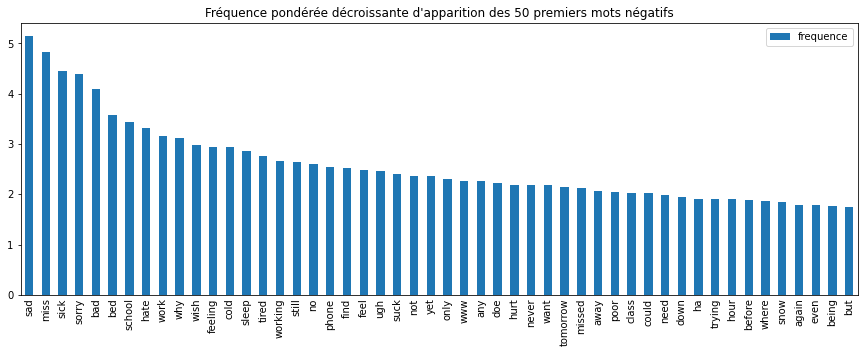

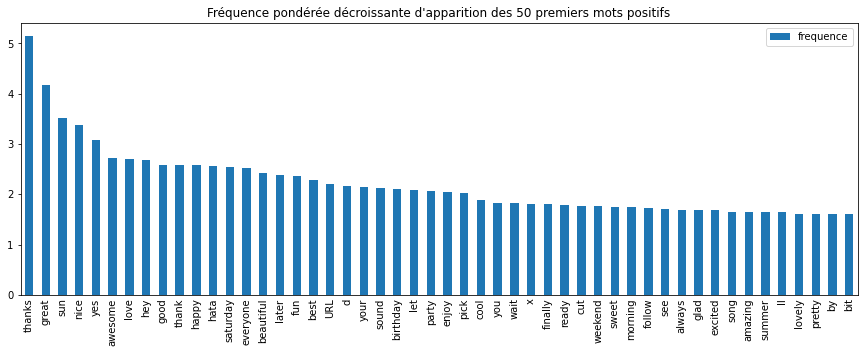

In [ ]:
cls.histogramme(50)

In [ ]:
pred = cls.predict_proba_class(bad_buzz_test.text_clean)

In [ ]:
pred.prediction = pred.prediction.apply(lambda x: 0 if x=='neg' else 4)
pred['reel'] = bad_buzz_test.target

pred

,confiance,prediction,reel
20000,0.073575,0,0
20001,0.065723,4,0
20002,0.120542,0,0
20003,0.057269,0,0
20004,0.041884,0,0
...,...,...,...
39995,0.043703,0,4
39996,0.046419,4,4
39997,0.044423,4,4
39998,0.004427,4,4


In [ ]:
accuracy = (pred.prediction == pred.reel).mean()
print("Notre modèle renvoie donc une prédiction de classe des commentaires, \n"
      "avec une précision de : {} %".format(100 * accuracy))

Notre modèle renvoie donc une prédiction de classe des commentaires, 
avec une précision de : 71.42500000000001 %


In [ ]:
conf_erreur_mean = pred.loc[pred.prediction != pred.reel].confiance.mean()
conf_glob_mean = pred.confiance.mean()

print(
    "La confiance moyenne générale moyenne est d'indice {:.4f}. \n"
    "Tandis que la confiance moyenne calculé uniquement sur les erreurs est de {:.4f}".
    format(conf_glob_mean, conf_erreur_mean)
)

La confiance moyenne générale moyenne est d'indice 0.0340. 
Tandis que la confiance moyenne calculé uniquement sur les erreurs est de 0.0089


On peut calculer une probabilité sur la justesse de la prédiction qui ait du sens. On ne le fera pas puisque c'est un modèle préliminaire.

In [ ]:
pred_anova = pd.DataFrame(
    {
        "confiance": pred.confiance,
        "justesse" : (pred.prediction == pred.reel).apply(lambda x: "juste" if x else "erreur")
    }
    )

In [ ]:
import pandas as pd
import numpy as np

def eta_squared(df, dependent_variable, factor):
    groups = df.groupby(factor)
    n = len(df)
    ss_total = ((df[dependent_variable] - df[dependent_variable].mean())**2).sum()
    ss_between = 0
    for group_name, group in groups:
        group_size = len(group)
        group_mean = group[dependent_variable].mean()
        ss_between += group_size * (group_mean - df[dependent_variable].mean())**2
    eta_squared = ss_between / ss_total
    return eta_squared


In [ ]:
def anova(df, variable, label):
    eta2 = eta_squared(df, variable, label)
    labels = df[label].unique()
    n_labels = labels.shape[0]
    box = []
    for i in labels:
        box += [df.loc[df[label] == i, variable]]
    medianprops = {'color': 'navy'}
    meanprops = {'marker': 'o', 'markeredgecolor': 'black', 'markerfacecolor': 'white'}
    plt.figure(figsize=(12, 8))
    box1 = plt.boxplot(box, labels=labels, vert=False, showmeans=True, showfliers=False, patch_artist=True,
                       medianprops=medianprops, meanprops=meanprops)
    color = ['peru', 'aquamarine', 'yellow', 'tomato', 'mediumorchid']
    for i in range(n_labels):
        plt.setp(box1["boxes"][i], facecolor=color[i % n_labels])

    plt.title('Repartition de l\'indice de confiance en fonction de la justesse ou non de la prédiction', size=20)
    plt.figtext(0.15, 0.82, '$\eta^2$={}'.format(round(eta2, 3)), fontsize=15)
    plt.ylabel(variable)
    plt.show()

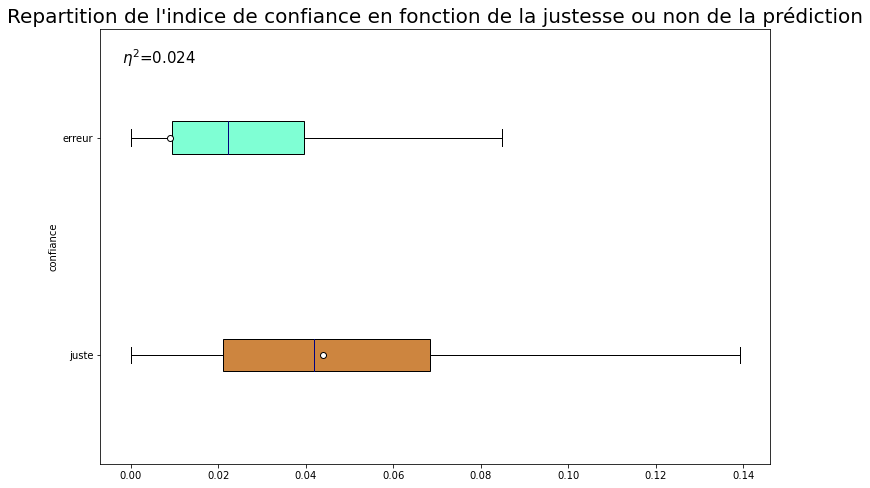

In [ ]:
anova(pred_anova, "confiance", "justesse")

## 2.2 Word Embedding - modèles classiques <a class="anchor" id="partie2_2"></a>

Nous allons tester des modèles de Word Embedding tels que Word2Vec et FastText. Ces modèles apprennent à représenter les mots sous forme de vecteurs en les retirant de leur contexte d'origine.

On va commencer par retirer quelques stopwords de nos commentaires afin d'amméliorer l'efficacité de notre embedding

In [ ]:
# Import de la fonction d'évaluation
from CoCl.metrique_classification_binaire import evaluate_model

In [ ]:
sw = set(df_freq.head(50).index)

In [ ]:
words_to_remove = set(
    ["good", "day", "go", "going", "like", "love", "no", "not", "now", "but", "out", "quit",
    "so", "that", "this", "time", "today", "too", "work", "with", "wa", "just", "you"]
    )

In [ ]:
stop_words = sw - words_to_remove

In [ ]:
stop_words

{'AT_USER',
 'URL',
 'a',
 'all',
 'am',
 'and',
 'are',
 'at',
 'be',
 'can',
 'do',
 'for',
 'get',
 'got',
 'have',
 'i',
 'in',
 'is',
 'it',
 'me',
 'my',
 'of',
 'on',
 'the',
 'to',
 'up',
 'will'}

In [ ]:
bad_buzz.text_clean = bad_buzz.text_clean.apply(lambda comm: [word for word in comm if word not in stop_words])

In [ ]:
bad_buzz.text_clean

0        [www, that, summer, you, should, david, care, ...
1        [upset, that, he, not, update, his, facebook, ...
2        [dived, many, time, ball, managed, save, rest,...
3                   [whole, body, feel, itchy, like, fire]
4        [no, not, behaving, mad, why, here, because, n...
                               ...                        
39995    [not, sleep, too, excited, decorating, baby, f...
39996    [hata, wonder, what, they, going, play, u, thu...
39997    [just, because, you, not, millionaire, doe, no...
39998    [watch, first, him, guess, wishing, friend, re...
39999    [morning, world, please, excuse, rabble, try, ...
Name: text_clean, Length: 40000, dtype: object

In [ ]:
bad_buzz.text_clean = bad_buzz.text_clean.apply(lambda x: ["COMMENTAIRE_INSIGNIFIANT"] if x == [] else x)

In [ ]:
bad_buzz.text_clean = bad_buzz.text_clean.apply(lambda x: ' '.join(x))
bad_buzz.text_clean

0        www that summer you should david care third day d
1        upset that he not update his facebook by testi...
2        dived many time ball managed save rest go out ...
3                          whole body feel itchy like fire
4        no not behaving mad why here because not see y...
                               ...                        
39995    not sleep too excited decorating baby first ap...
39996    hata wonder what they going play u thursday ma...
39997    just because you not millionaire doe not mean ...
39998    watch first him guess wishing friend reunion o...
39999    morning world please excuse rabble try discove...
Name: text_clean, Length: 40000, dtype: object

In [ ]:
bad_buzz[["target", "text_clean"]].to_csv("bad_buzz_ready4analysis.csv", sep="\t", index=False)

### 2.2.1- Word2Vec <a class="anchor" id="partie2_2_1"></a>

In [ ]:
bad_buzz = pd.read_csv("bad_buzz_ready4analysis.csv", sep="\t")
bad_buzz.text_clean = bad_buzz.text_clean.apply(lambda x: x.split(" "))
bad_buzz.text_clean

0        [www, that, summer, you, should, david, care, ...
1        [upset, that, he, not, update, his, facebook, ...
2        [dived, many, time, ball, managed, save, rest,...
3                   [whole, body, feel, itchy, like, fire]
4        [no, not, behaving, mad, why, here, because, n...
                               ...                        
39995    [not, sleep, too, excited, decorating, baby, f...
39996    [hata, wonder, what, they, going, play, u, thu...
39997    [just, because, you, not, millionaire, doe, no...
39998    [watch, first, him, guess, wishing, friend, re...
39999    [morning, world, please, excuse, rabble, try, ...
Name: text_clean, Length: 40000, dtype: object

In [ ]:
from gensim.models import Word2Vec

# Créer une liste de phrases à partir de la colonne "text_clean" du dataframe
sentences = bad_buzz.text_clean.tolist()

# Entraîner le modèle Word2Vec avec la méthode CBOW
model = Word2Vec(sentences, sg=0, size=100, min_count=1, workers=8)


In [ ]:
# Combinaison des listes de mots en une seule liste
all_words = [word for comment in bad_buzz['text_clean'] for word in comment]

# Récupération des vecteurs pour tous les mots
vectors = model.wv[all_words]

# Création d'un dictionnaire pour accéder aux vecteurs par mot
word_vectors = {word: vectors[i] for i, word in enumerate(all_words)}


#### $\color{ #1b4f72 }{\textbf{Méthode 1 : }\text{Moyenne des mots pour chaque commentaire}}$

In [ ]:
# Création d'une colonne 'vect' contenant les vecteurs de chaque commentaire
bad_buzz['vect'] = bad_buzz['text_clean'].apply(lambda comment: np.mean([word_vectors[word] for word in comment if word in word_vectors], axis=0))


* __ACP__

In [ ]:
# Préparation des données pour former un dataframe
vect_comm = bad_buzz.vect.apply(pd.Series)

vect_comm


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.065848,0.303594,-0.563081,-0.084446,0.152409,0.306275,0.540128,-0.565112,0.302031,-0.214941,...,-0.533234,-0.216864,0.167377,-0.558920,-0.351904,-0.898973,0.045731,0.106161,0.372786,-0.203419
1,-0.116900,0.254747,-0.380483,-0.191823,0.063668,0.265441,0.363854,-0.420573,0.365913,-0.249007,...,-0.504409,-0.189008,0.105133,-0.564186,-0.402941,-0.701658,-0.051611,0.064566,0.293874,-0.142095
2,-0.076118,0.100381,-0.454906,-0.101376,0.063265,0.084628,0.373087,-0.356010,0.291173,-0.163353,...,-0.506441,-0.079219,0.064087,-0.484324,-0.251713,-0.529796,-0.049590,-0.080135,0.149507,0.087102
3,0.078852,0.388441,-0.294905,-0.004611,0.165880,0.363071,0.312639,-0.509277,0.370388,-0.302651,...,-0.401798,0.000228,0.174529,-0.626554,-0.498793,-0.762956,-0.131289,0.097055,0.197509,-0.259844
4,-0.068852,0.291823,-0.529199,-0.331554,0.248692,0.256777,0.469944,-0.741807,0.254283,-0.200654,...,-0.565068,-0.371751,0.168654,-0.587397,-0.344377,-1.031482,0.209233,0.014118,0.531465,-0.253027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.072057,0.293982,-0.526213,-0.204679,0.171573,0.270363,0.547196,-0.672441,0.386821,-0.365164,...,-0.687153,-0.071999,0.269121,-0.591183,-0.397183,-0.927217,-0.016170,-0.030806,0.319420,-0.205074
39996,-0.003861,0.300336,-0.435637,-0.250343,0.192817,0.370126,0.433430,-0.535793,0.192714,-0.188746,...,-0.537927,-0.272905,0.164184,-0.578180,-0.365078,-0.897297,0.124992,0.192789,0.468534,-0.273818
39997,-0.033512,0.435791,-0.462765,-0.143848,0.230569,0.439321,0.453665,-0.725854,0.358759,-0.257681,...,-0.511147,-0.295704,0.115662,-0.524423,-0.347761,-0.804168,0.182414,0.189411,0.428465,-0.360587
39998,-0.310214,0.248366,-0.350813,-0.313723,0.033157,0.173275,0.364205,-0.394845,0.426589,-0.455440,...,-0.697364,-0.186048,0.258467,-0.417051,-0.399003,-0.774410,0.120753,0.131662,0.248920,-0.236023


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Standardisation des données
scaler = StandardScaler()
vect_comm_std = scaler.fit_transform(vect_comm)

# Calcul des composantes principales
n_comp=0.99

pca = PCA(n_components=n_comp)
res_vect_comm = pca.fit_transform(vect_comm_std)


# Observation de différentes variables calculées
print('Voici les pourcentages de la variance expliqué par les 3 premiers axes : {}'.format(pca.explained_variance_ratio_[:3]))
print('Notre base de donnée passe de \033[1m {} \033[0m à \033[1m {} \033[0m dimmensions après l\'acp, pour une perte d\'information de seulement 1%.'.format(vect_comm_std.shape[1], res_vect_comm.shape[1]))


Voici les pourcentages de la variance expliqué par les 3 premiers axes : [0.24882701 0.20578513 0.13885388]
Notre base de donnée passe de  100  à  20  dimmensions après l'acp, pour une perte d'information de seulement 1%.


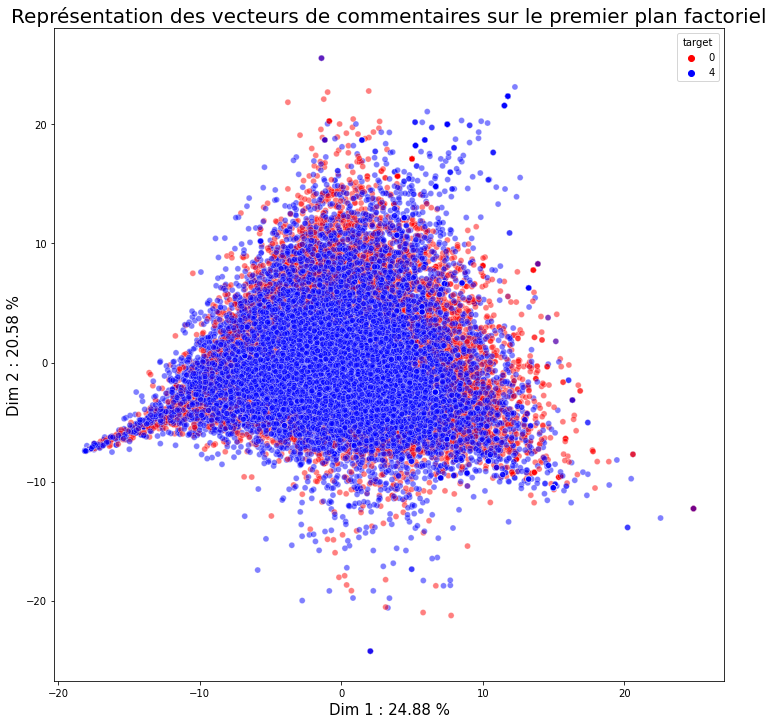

In [ ]:
import seaborn as sns
# visualisation des observations sur l'axe principal de l'ACP, avec couleurs selon les scores
fig = plt.figure(figsize=(12,12))

palette={0:'red', 4:'blue'}
g= sns.scatterplot(x=res_vect_comm[:,0], y=res_vect_comm[:,1], hue=bad_buzz.target, 
                hue_order=[0, 4], alpha=0.5, palette=palette)
    
plt.title("Représentation des vecteurs de commentaires sur le premier plan factoriel", size=20)
g.set_xlabel("Dim 1 : " + str(round(pca.explained_variance_ratio_[0]*100,2)) + " %", fontsize=15)
g.set_ylabel("Dim 2 : " + str(round(pca.explained_variance_ratio_[1]*100,2)) + " %", fontsize=15) 
plt.show()

* __T-SNE__ à partir des données transformées via l'ACP

In [ ]:
%%time
pas = 40
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=100,
                     n_iter=500, init='random',
                     random_state=6, learning_rate=200.0
                     )
X_tsne = tsne.fit_transform(res_vect_comm[::pas])

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = np.array(bad_buzz.target)[::pas]
print(df_tsne.shape)

(1000, 3)
CPU times: total: 39 s
Wall time: 5.67 s


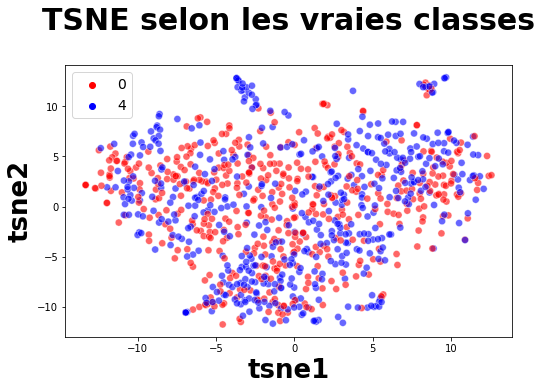

In [ ]:
plt.figure(figsize=(8,5))

palette={0:'red', 4:'blue'}
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=palette, s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

__Préliminaire pour l'entraînement des modèles :__ séparations des données d'entraînement et de test

In [ ]:
X = res_vect_comm
y = bad_buzz.target

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


$\color{ #549be2 }{\textbf{1er modèle : régression logistique}}$

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Entraîner le modèle
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = clf.predict(X_test)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.65


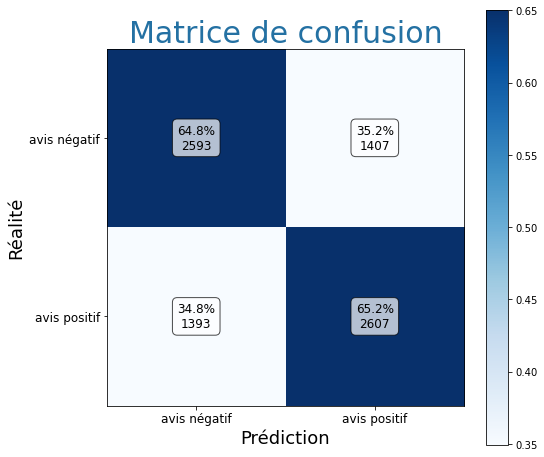

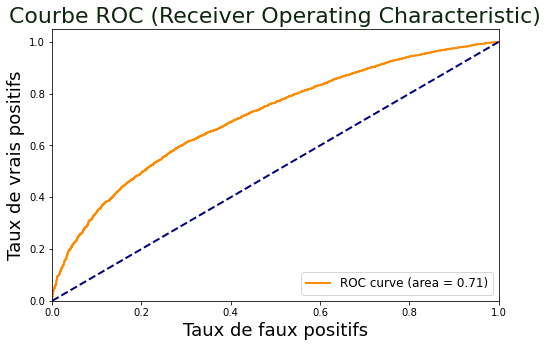

In [ ]:
evaluate_model(clf, X_test, y_test)

$\color{#549be2}{\textbf{2ème modèle : Forêt aléatoire}}$

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de forêt aléatoire
rf = RandomForestClassifier(n_estimators=100, max_depth=12, max_features="sqrt",
                            max_samples=0.8, random_state=42, n_jobs=8)
rf.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = rf.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.674


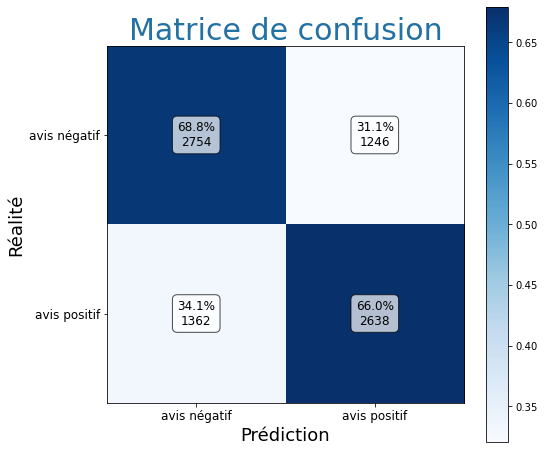

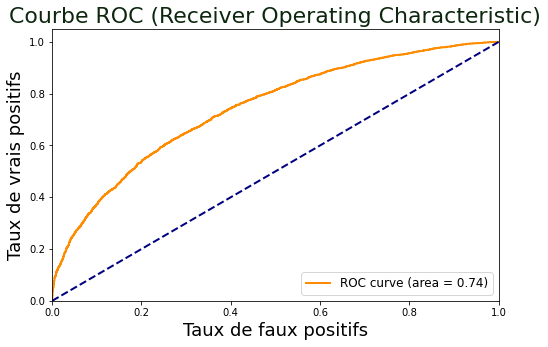

In [ ]:
evaluate_model(rf, X_test, y_test)

$\color{#549be2}{\textbf{3ème modèle : Gradient boosting tree}}$

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de gradient boosting
gb = GradientBoostingClassifier(n_estimators=100, subsample=0.8, max_features="sqrt",
                                max_depth=8, tol=5, random_state=42)
gb.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = gb.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.677375


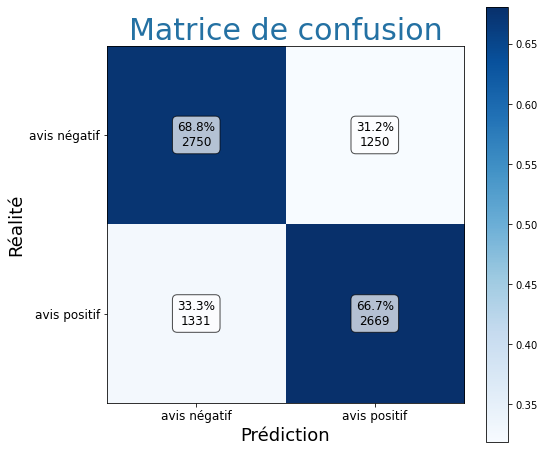

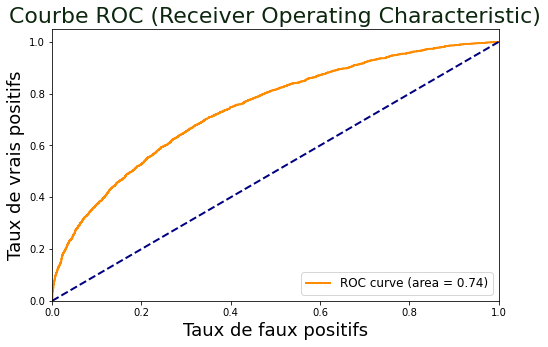

In [ ]:
evaluate_model(gb, X_test, y_test)

#### $\color{#1b4f72}{\textbf{Méthode 2 : }\text{TF-IDF}}$

In [ ]:
bad_buzz_tf_idf = bad_buzz.loc[:, ["target"]].copy()

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Créer une instance de TfidfVectorizer
alpha = 0.001
beta = 0.99
tfidf_vectorizer = TfidfVectorizer(min_df=alpha, max_df=beta)
# tfidf_vectorizer = TfidfVectorizer()

# Convertir les commentaires en une matrice sparse de coefficients tf-idf
tfidf_matrix = tfidf_vectorizer.fit_transform(bad_buzz.text_clean.apply(lambda x: ' '.join(x)))

# Récupérer la liste des mots de la matrice
words_list = tfidf_vectorizer.get_feature_names_out()

# Ajouter la colonne vect_tf_idf au DataFrame original
bad_buzz_tf_idf['vect_tf_idf'] = list(tfidf_matrix.toarray())

# Convertir la liste de vecteurs en une liste de dictionnaires
dict_list = []
for vector in bad_buzz_tf_idf['vect_tf_idf']:
    # Filtrer les coefficients non nuls
    non_zero_indices = vector.nonzero()[0]
    # Créer un dictionnaire contenant les mots et les coefficients correspondants
    dict_list.append({words_list[i]: vector[i] for i in non_zero_indices})

# Remplacer la colonne vect_tf_idf par la liste de dictionnaires
bad_buzz_tf_idf['vect_tf_idf'] = dict_list


CPU times: total: 1.8 s
Wall time: 1.81 s


In [ ]:
bad_buzz_tf_idf['vect_tf_idf'] = bad_buzz_tf_idf['vect_tf_idf'].apply(
    lambda comment: np.sum([facteur * word_vectors[word] for word, facteur in comment.items() 
                            if word in word_vectors], axis=0))

* ACP

In [ ]:
# Préparation des données pour former un dataframe
vect_comm = bad_buzz_tf_idf.vect_tf_idf.apply(pd.Series)

vect_comm


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.139463,0.806873,-1.562856,-0.254215,0.415864,0.777174,1.472575,-1.536998,0.865058,-0.670520,...,-1.524580,-0.549567,0.467027,-1.581338,-1.015345,-2.429868,0.079390,0.265871,0.988388,-0.532483
1,-0.426706,0.851267,-1.460531,-0.687012,0.189499,0.994160,1.376636,-1.453568,1.356970,-0.896451,...,-1.944408,-0.617965,0.374880,-2.111661,-1.548867,-2.545129,-0.275498,0.214519,0.998987,-0.447002
2,-0.251388,0.380693,-1.362215,-0.297647,0.187518,0.361093,1.168938,-1.078174,0.920606,-0.585555,...,-1.573591,-0.243615,0.233600,-1.460282,-0.825524,-1.657695,-0.165437,-0.183348,0.470190,0.142432
3,0.073665,0.832936,-0.721902,-0.033398,0.319232,0.783653,0.741543,-1.082880,0.899105,-0.716133,...,-0.998363,-0.043817,0.367487,-1.410370,-1.142135,-1.717982,-0.320184,0.208360,0.436047,-0.524523
4,-0.233664,0.822720,-1.758895,-1.086168,0.701479,0.808598,1.576495,-2.167967,0.813740,-0.723791,...,-2.023654,-1.054002,0.587177,-1.972016,-1.232765,-3.263854,0.518136,0.081844,1.604065,-0.740576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.280872,0.861515,-1.633590,-0.646287,0.446709,0.801497,1.732273,-1.936001,1.277621,-1.263613,...,-2.307391,-0.112793,0.869769,-1.905529,-1.329984,-2.822899,-0.201215,-0.138142,0.867982,-0.581970
39996,-0.144877,1.081866,-1.483665,-0.802997,0.552811,1.272207,1.489036,-1.694170,0.791824,-0.767100,...,-1.941678,-0.845361,0.547129,-1.931864,-1.266838,-3.017140,0.318961,0.666368,1.507945,-0.942951
39997,-0.164259,1.369960,-1.628249,-0.417804,0.661225,1.521163,1.614205,-2.191225,1.263251,-0.961784,...,-1.935759,-0.836442,0.412378,-1.827259,-1.301825,-2.608123,0.415573,0.691603,1.288327,-1.133782
39998,-0.927184,0.768306,-1.102559,-0.930824,0.107748,0.528383,1.150692,-1.222020,1.305367,-1.404054,...,-2.138123,-0.551597,0.783110,-1.295558,-1.212643,-2.360936,0.339037,0.375141,0.759515,-0.702374


In [ ]:
bad_buzz.loc[vect_comm.loc[vect_comm.isna().any(axis=1),:].index].to_csv('commentaire_insignifiant.csv', sep='\t', index=False)

In [ ]:
print('Nombre de "vecteurs commentaires" vides : ', vect_comm.isna().any(axis=1).sum())

Nombre de "vecteurs commentaires" vides :  379


Pour les commentaire vide, on fait ici le choix de les remplir par le vecteur moyen du commentaire correspondant. Voir méthode précédente. 

In [ ]:
vecteurs_vides = vect_comm.isna().any(axis=1)

vect_comm[vecteurs_vides] = \
    bad_buzz.text_clean[vecteurs_vides].apply(
    lambda comment: np.mean([word_vectors[word] for word in comment if word in word_vectors], axis=0))\
    .apply(lambda x: pd.Series(x))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Standardisation des données
scaler = StandardScaler()
vect_comm_std = scaler.fit_transform(vect_comm)

# Calcul des composantes principales
n_comp=0.99

pca = PCA(n_components=n_comp)
res_vect_comm = pca.fit_transform(vect_comm_std)


# Observation de différentes variables calculées
print('Voici les pourcentages de la variance expliqué par les 3 premiers axes : {}'.format(pca.explained_variance_ratio_[:3]))
print('Notre base de donnée passe de \033[1m {} \033[0m à \033[1m {} \033[0m dimmensions après l\'acp, pour une perte d\'information de seulement 1%.'.format(vect_comm_std.shape[1], res_vect_comm.shape[1]))


Voici les pourcentages de la variance expliqué par les 3 premiers axes : [0.3827625  0.17376878 0.11921931]
Notre base de donnée passe de  100  à  18  dimmensions après l'acp, pour une perte d'information de seulement 1%.


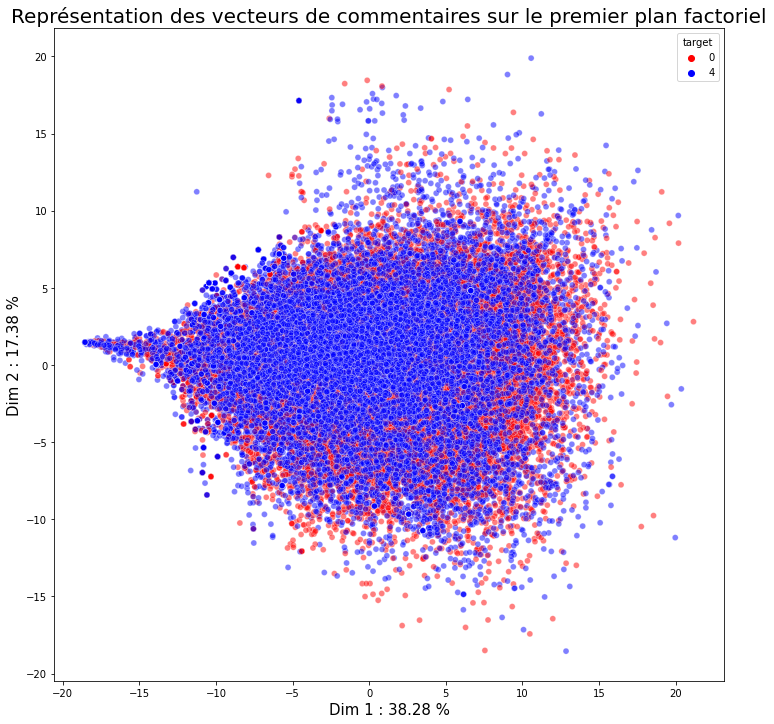

In [ ]:
import seaborn as sns
# visualisation des observations sur l'axe principal de l'ACP, avec couleurs selon les scores
fig = plt.figure(figsize=(12,12))

palette={0:'red', 4:'blue'}
g= sns.scatterplot(x=res_vect_comm[:,0], y=res_vect_comm[:,1], hue=bad_buzz.target, 
                hue_order=[0, 4], alpha=0.5, palette=palette)
    
plt.title("Représentation des vecteurs de commentaires sur le premier plan factoriel", size=20)
g.set_xlabel("Dim 1 : " + str(round(pca.explained_variance_ratio_[0]*100,2)) + " %", fontsize=15)
g.set_ylabel("Dim 2 : " + str(round(pca.explained_variance_ratio_[1]*100,2)) + " %", fontsize=15) 
plt.show()

* T-SNE à partir des données transformées via l'ACP

In [ ]:
%%time
pas = 40
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=100,
                     n_iter=500, init='random',
                     random_state=6, learning_rate=200.0
                     )
X_tsne = tsne.fit_transform(res_vect_comm[::pas])

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = np.array(bad_buzz.target)[::pas]
print(df_tsne.shape)

(1000, 3)
CPU times: total: 39 s
Wall time: 5.56 s


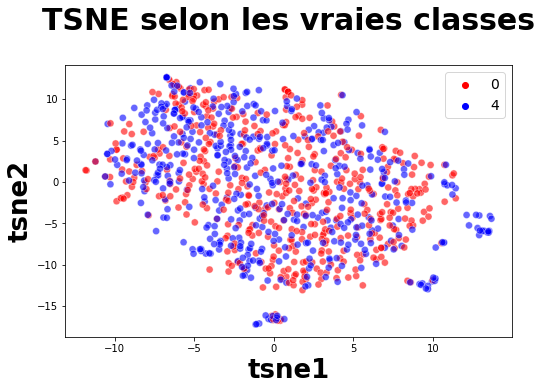

In [ ]:
plt.figure(figsize=(8,5))

palette={0:'red', 4:'blue'}
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=palette, s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

__Préliminaire pour l'entraînement des modèles :__ séparations des données d'entraînement et de test

In [ ]:
X = res_vect_comm
y = bad_buzz.target

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


$\color{ #549be2 }{\textbf{1er modèle : régression logistique}}$

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Entraîner le modèle
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = clf.predict(X_test)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6505


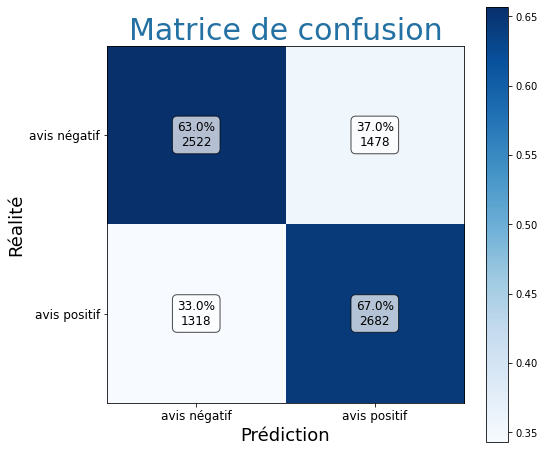

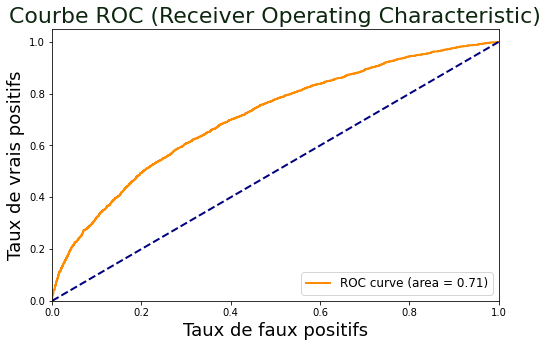

In [ ]:
evaluate_model(clf, X_test, y_test)

$\color{#549be2}{\textbf{2ème modèle : Forêt aléatoire}}$

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de forêt aléatoire
rf = RandomForestClassifier(n_estimators=150, max_depth=15, max_features="sqrt",
                            max_samples=0.5, random_state=42, n_jobs=8)
rf.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = rf.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.687875


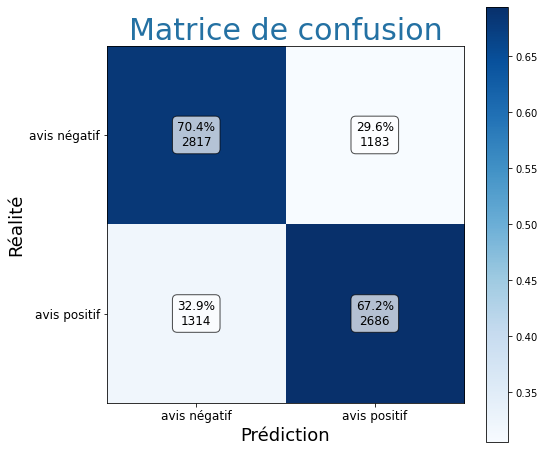

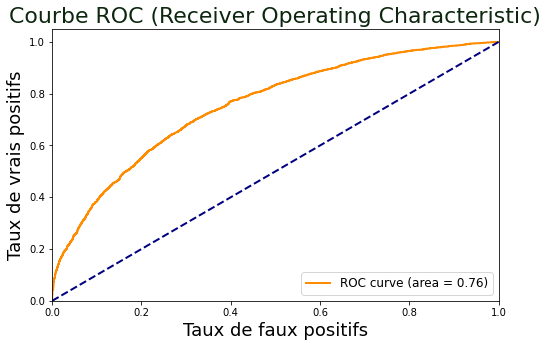

In [ ]:
evaluate_model(rf, X_test, y_test)

$\color{#549be2}{\textbf{3ème modèle : Gradient boosting tree}}$

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de gradient boosting
gb = GradientBoostingClassifier(n_estimators=150, subsample=0.5, max_features="sqrt",
                                max_depth=15, tol=5, random_state=42)
gb.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = gb.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.66825


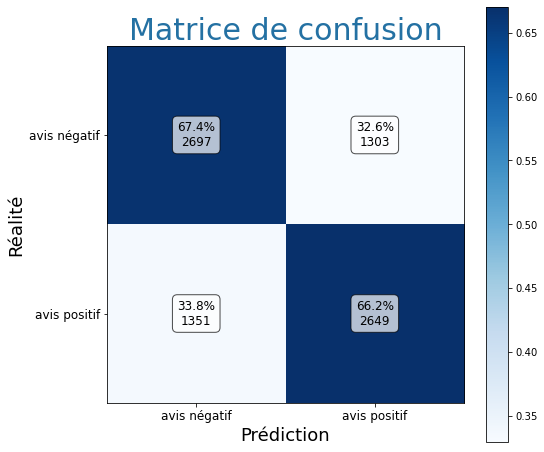

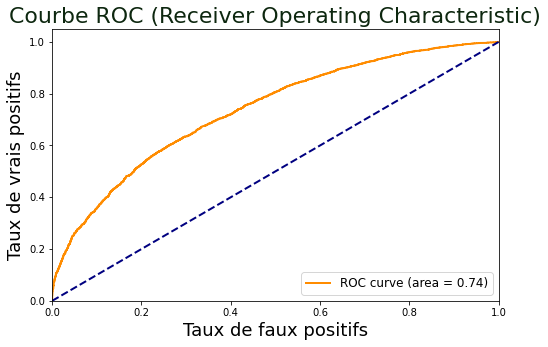

In [ ]:
evaluate_model(gb, X_test, y_test)

### 2.2.2- Doc2Vec <a class="anchor" id="partie2_2_2"></a>

In [ ]:
%%time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Création d'une liste de TaggedDocuments
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(bad_buzz['text_clean'])]

# Entraînement d'un modèle Doc2Vec
model = Doc2Vec(documents, vector_size=100, window=5, min_count=5, epochs=20)

# Enregistrement des vecteurs de chaque commentaire
bad_buzz_doc2vec = bad_buzz['text_clean'].apply(lambda words: model.infer_vector(words))


CPU times: total: 2min 1s
Wall time: 1min 46s


In [ ]:
bad_buzz_doc2vec

0        [-0.07218103, 0.09767012, -0.0634843, -0.07018...
1        [0.054877933, 0.21786283, 0.22407678, -0.13728...
2        [-0.00443515, -0.13831994, -0.13829327, -0.148...
3        [-0.04549303, 0.09864129, -0.030031744, -0.071...
4        [-0.17233849, 0.08572401, -0.18260343, -0.2793...
                               ...                        
39995    [0.26899457, -0.0995954, 0.1571162, -0.1049725...
39996    [-0.19614646, 0.14618105, -0.24460913, 0.08163...
39997    [-0.1328587, -0.06884746, -0.055650156, 0.2471...
39998    [-0.014648261, 0.12800156, -0.0133941565, -0.3...
39999    [0.00074751826, 0.0880611, -0.08595229, -0.029...
Name: text_clean, Length: 40000, dtype: object

* ACP

In [ ]:
# Préparation des données pour former un dataframe
bad_buzz_doc2vec = bad_buzz_doc2vec.apply(pd.Series)

bad_buzz_doc2vec


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.072181,0.097670,-0.063484,-0.070181,-0.056571,-0.032895,0.086569,0.124029,0.165836,-0.223359,...,-0.134496,0.193577,-0.088596,0.223226,0.004933,0.141601,-0.025312,0.195281,-0.180302,-0.013878
1,0.054878,0.217863,0.224077,-0.137287,-0.122237,0.042024,-0.113111,-0.046500,0.008504,-0.036768,...,-0.164313,0.151345,-0.155974,0.005640,-0.103775,0.238657,-0.097068,-0.184335,0.226215,0.013687
2,-0.004435,-0.138320,-0.138293,-0.148444,-0.176832,0.028029,-0.181131,-0.188777,0.144747,0.031882,...,0.051159,0.021539,-0.053080,0.033367,-0.035925,-0.048290,-0.060054,-0.046683,-0.022098,0.108908
3,-0.045493,0.098641,-0.030032,-0.071797,0.060348,0.067779,-0.008165,-0.098014,0.037449,-0.040048,...,-0.022797,-0.011642,-0.002800,-0.064453,-0.073519,-0.167962,0.022803,-0.057266,0.015022,-0.054019
4,-0.172338,0.085724,-0.182603,-0.279340,-0.010189,-0.065324,0.072328,-0.222192,0.050976,0.222878,...,-0.252998,-0.023475,0.255483,-0.179662,-0.102996,-0.132303,-0.043491,0.195075,0.040292,0.145633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.268995,-0.099595,0.157116,-0.104973,-0.131636,-0.104816,0.108882,-0.059388,0.194693,0.110174,...,0.159503,0.052961,0.213890,0.171539,-0.249168,0.041842,-0.001083,0.032660,0.080050,0.119283
39996,-0.196146,0.146181,-0.244609,0.081634,-0.496675,0.612992,0.390023,0.182377,-0.224256,-0.005725,...,-0.006121,-0.372547,0.045841,0.123924,0.250900,0.148140,0.121340,0.161745,-0.117009,-0.223211
39997,-0.132859,-0.068847,-0.055650,0.247103,-0.201722,-0.245870,0.117549,-0.174711,0.043181,-0.278974,...,-0.029857,0.101398,0.040303,-0.098772,-0.113021,-0.042790,-0.065360,-0.011479,0.066197,-0.213413
39998,-0.014648,0.128002,-0.013394,-0.309042,-0.025075,0.038249,0.123317,0.051852,0.163271,-0.157828,...,0.021283,0.108295,0.146621,0.033714,0.134171,0.116488,0.106090,-0.104322,-0.251219,-0.167133


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Standardisation des données
scaler = StandardScaler()
vect_comm_std = scaler.fit_transform(bad_buzz_doc2vec)

# Calcul des composantes principales
n_comp=0.99

pca = PCA(n_components=n_comp)
res_vect_comm = pca.fit_transform(vect_comm_std)


# Observation de différentes variables calculées
print('Voici les pourcentages de la variance expliqué par les 3 premiers axes : {}'.format(pca.explained_variance_ratio_[:3]))
print('Notre base de donnée passe de \033[1m {} \033[0m à \033[1m {} \033[0m dimmensions après l\'acp, pour une perte d\'information de seulement 1%.'.format(vect_comm_std.shape[1], res_vect_comm.shape[1]))


Voici les pourcentages de la variance expliqué par les 3 premiers axes : [0.05415666 0.03564015 0.0339354 ]
Notre base de donnée passe de  100  à  84  dimmensions après l'acp, pour une perte d'information de seulement 1%.


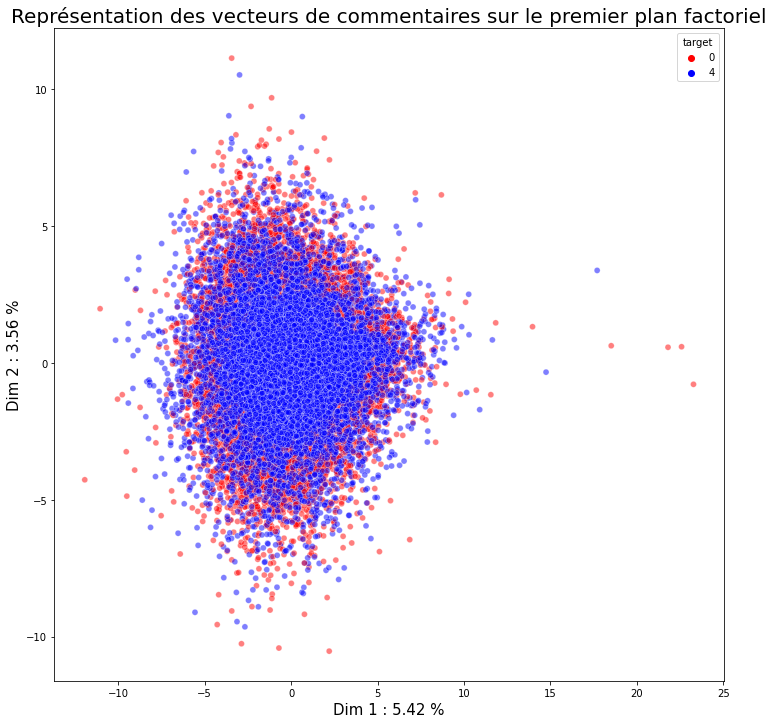

In [ ]:
import seaborn as sns
# visualisation des observations sur l'axe principal de l'ACP, avec couleurs selon les scores
fig = plt.figure(figsize=(12,12))

palette={0:'red', 4:'blue'}
g= sns.scatterplot(x=res_vect_comm[:,0], y=res_vect_comm[:,1], hue=bad_buzz.target, 
                hue_order=[0, 4], alpha=0.5, palette=palette)
    
plt.title("Représentation des vecteurs de commentaires sur le premier plan factoriel", size=20)
g.set_xlabel("Dim 1 : " + str(round(pca.explained_variance_ratio_[0]*100,2)) + " %", fontsize=15)
g.set_ylabel("Dim 2 : " + str(round(pca.explained_variance_ratio_[1]*100,2)) + " %", fontsize=15) 
plt.show()

* T-SNE à partir des données transformées via l'ACP

In [ ]:
%%time
pas = 40
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=100,
                     n_iter=500, init='random',
                     random_state=6, learning_rate=200.0
                     )
X_tsne = tsne.fit_transform(res_vect_comm[::pas])

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = np.array(bad_buzz.target)[::pas]
print(df_tsne.shape)

(1000, 3)
CPU times: total: 30.2 s
Wall time: 4.14 s


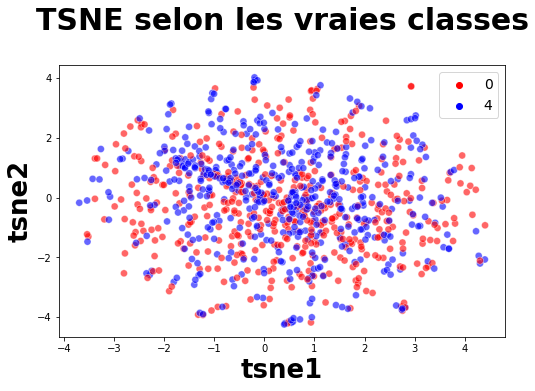

In [ ]:
plt.figure(figsize=(8,5))

palette={0:'red', 4:'blue'}
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=palette, s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

__Préliminaire pour l'entraînement des modèles :__ séparations des données d'entraînement et de test

In [ ]:
X = res_vect_comm
y = bad_buzz.target

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


$\color{ #549be2 }{\textbf{1er modèle : régression logistique}}$

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Entraîner le modèle
clf_d2v = LogisticRegression()
clf_d2v.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = clf_d2v.predict(X_test)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.700625


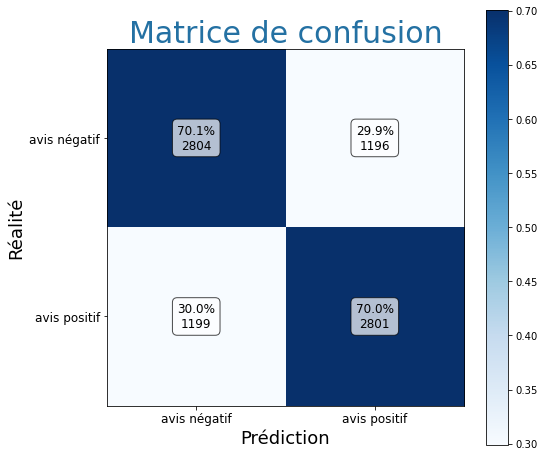

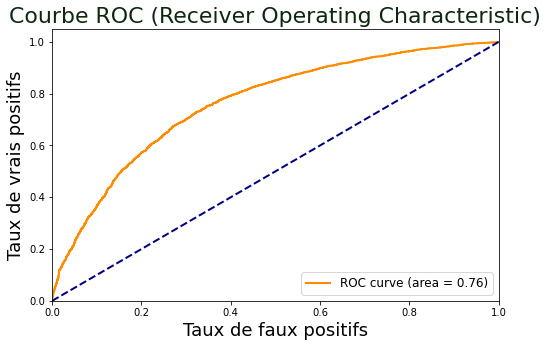

In [ ]:
evaluate_model(clf_d2v, X_test, y_test)

$\color{#549be2}{\textbf{2ème modèle : Forêt aléatoire}}$

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de forêt aléatoire
rf_d2v = RandomForestClassifier(n_estimators=150, max_depth=12, max_features="sqrt",
                            max_samples=0.8, random_state=42, n_jobs=8)
rf_d2v.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = rf_d2v.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.696


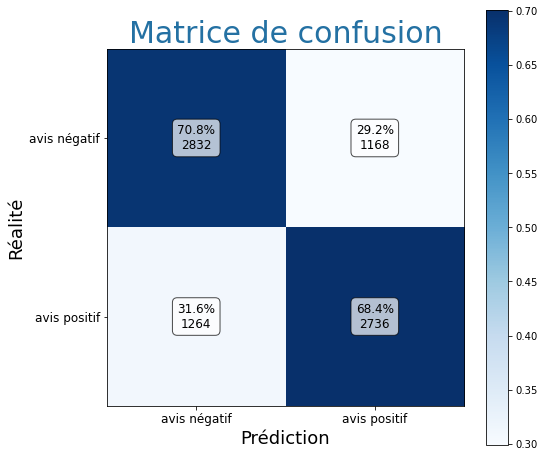

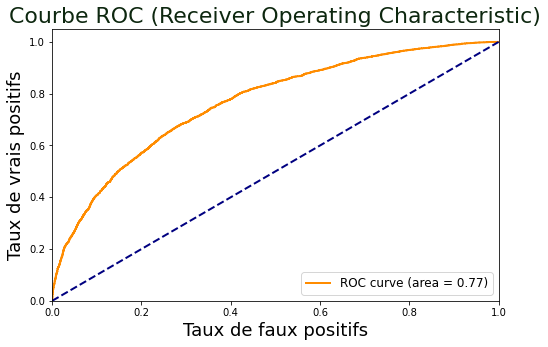

In [ ]:
evaluate_model(rf_d2v, X_test, y_test)

$\color{#549be2}{\textbf{3ème modèle : Gradient boosting tree}}$

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de gradient boosting
gb_d2v = GradientBoostingClassifier(n_estimators=250, subsample=0.5, max_features="sqrt",
                                max_depth=5, tol=5, random_state=42)
gb_d2v.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = gb_d2v.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7085


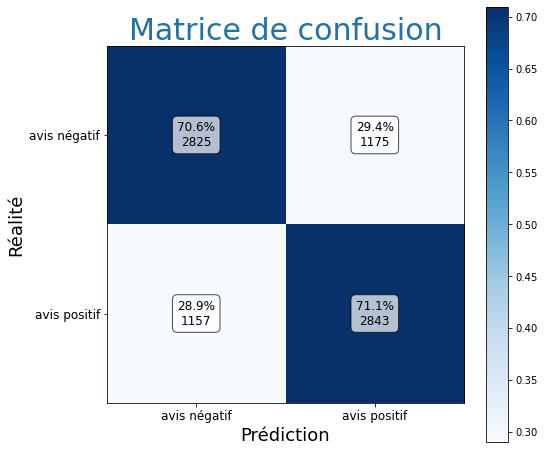

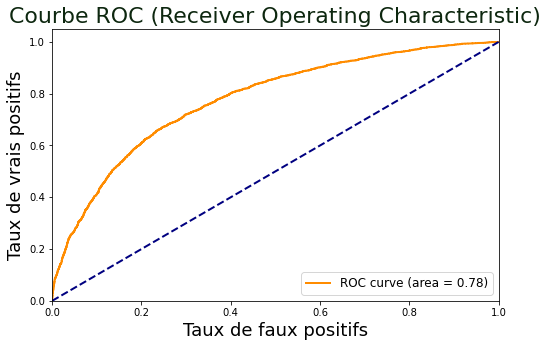

In [ ]:
evaluate_model(gb_d2v, X_test, y_test)

$\color{#549be2}{\textbf{4ème modèle : Méthode d'ensemble avec combinaison des modèles précédents}}$

In [ ]:
from sklearn.ensemble import StackingClassifier

# Création du stacking classifier avec les 3 modèles entraînés
estimators = [('clf', clf), ('rf', rf), ('gb', gb)]
stacking_clf_d2v = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Entraînement du modèle sur les données d'entraînement
stacking_clf_d2v.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = stacking_clf_d2v.predict(X_test)

# Évaluation des performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : ", accuracy)


Accuracy :  0.716375


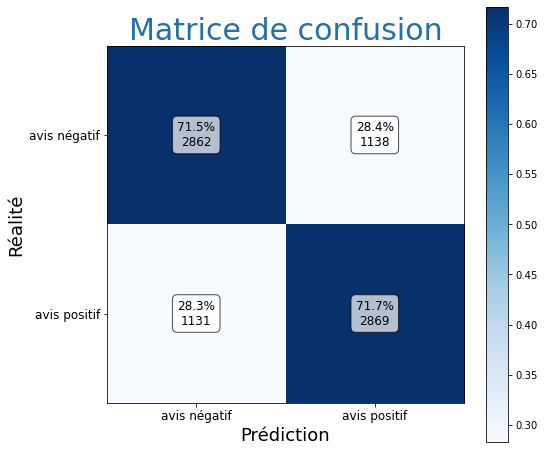

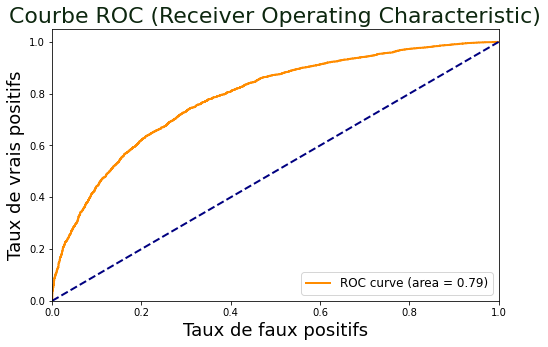

In [ ]:
evaluate_model(stacking_clf_d2v, X_test, y_test)

### 2.2.3- FastText <a class="anchor" id="partie2_2_3"></a>

In [ ]:
%%time
from gensim.models.fasttext import FastText

# Entraînement d'un modèle FastText
model = FastText(sentences=bad_buzz['text_clean'], size=100, window=5, min_count=5, iter=20)

# Enregistrement des vecteurs de chaque commentaire
bad_buzz_fasttext = bad_buzz['text_clean'].apply(lambda words: model.wv[words].mean(axis=0))


CPU times: total: 1min 24s
Wall time: 38.2 s


* ACP

In [ ]:
# Préparation des données pour former un dataframe
bad_buzz_fasttext = bad_buzz_fasttext.apply(pd.Series)

bad_buzz_fasttext.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.370781,-0.362630,0.049764,-0.630412,-0.238452,0.460047,0.149513,0.001376,0.410433,-0.040437,...,0.078832,-0.377703,0.259227,0.580886,0.143087,-0.455917,-0.825940,-0.278090,-0.082033,-0.397296
1,0.198014,-0.251593,0.142791,0.148161,0.040631,-0.179574,-0.482364,0.037756,0.505640,-0.770145,...,0.106475,0.006160,0.546854,-0.306628,0.525701,0.177737,0.190671,0.310470,-0.371235,0.063139
2,0.055293,-0.365584,-0.393405,-0.632628,0.324464,0.087949,-0.736191,0.294741,0.642618,-0.395715,...,0.538292,-0.260304,0.149201,0.587146,0.115382,0.420900,0.162340,-0.067109,-0.463887,-0.540469
3,0.324527,-0.251350,-0.119870,0.627514,-0.708022,-0.275457,0.759912,0.125662,0.221100,-0.636143,...,0.651982,0.325040,0.237747,-0.014825,0.174264,0.686574,0.249616,0.493632,0.070822,-0.520386
4,-0.261727,-0.759748,-0.460158,-0.597782,-0.277897,-0.251628,-0.651643,-0.108632,0.452506,-0.101285,...,-0.335184,-0.796118,-0.450817,-0.393966,0.214397,0.445543,-0.654572,-0.081023,-0.405750,-0.185591


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Standardisation des données
scaler = StandardScaler()
vect_comm_std = scaler.fit_transform(bad_buzz_fasttext)

# Calcul des composantes principales
n_comp=0.99

pca = PCA(n_components=n_comp)
res_vect_comm = pca.fit_transform(vect_comm_std)


# Observation de différentes variables calculées
print('Voici les pourcentages de la variance expliqué par les 3 premiers axes : {}'.format(pca.explained_variance_ratio_[:3]))
print('Notre base de donnée passe de \033[1m {} \033[0m à \033[1m {} \033[0m dimmensions après l\'acp, pour une perte d\'information de seulement 1%.'.format(vect_comm_std.shape[1], res_vect_comm.shape[1]))


Voici les pourcentages de la variance expliqué par les 3 premiers axes : [0.10395327 0.0740353  0.06131063]
Notre base de donnée passe de  100  à  74  dimmensions après l'acp, pour une perte d'information de seulement 1%.


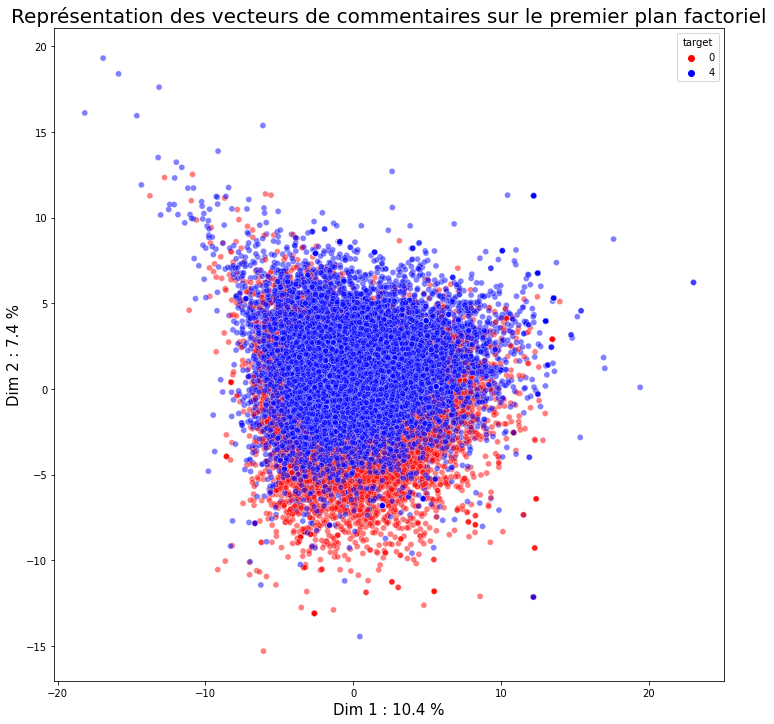

In [ ]:
import seaborn as sns
# visualisation des observations sur l'axe principal de l'ACP, avec couleurs selon les scores
fig = plt.figure(figsize=(12,12))

palette={0:'red', 4:'blue'}
g= sns.scatterplot(x=res_vect_comm[:,0], y=res_vect_comm[:,1], hue=bad_buzz.target, 
                hue_order=[0, 4], alpha=0.5, palette=palette)
    
plt.title("Représentation des vecteurs de commentaires sur le premier plan factoriel", size=20)
g.set_xlabel("Dim 1 : " + str(round(pca.explained_variance_ratio_[0]*100,2)) + " %", fontsize=15)
g.set_ylabel("Dim 2 : " + str(round(pca.explained_variance_ratio_[1]*100,2)) + " %", fontsize=15) 
plt.show()

* T-SNE à partir des données transformées via l'ACP

In [ ]:
%%time
pas = 40
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=100,
                     n_iter=500, init='random',
                     random_state=6, learning_rate=200.0
                     )
X_tsne = tsne.fit_transform(res_vect_comm[::pas])

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = np.array(bad_buzz.target)[::pas]
print(df_tsne.shape)

(1000, 3)
CPU times: total: 27.2 s
Wall time: 3.69 s


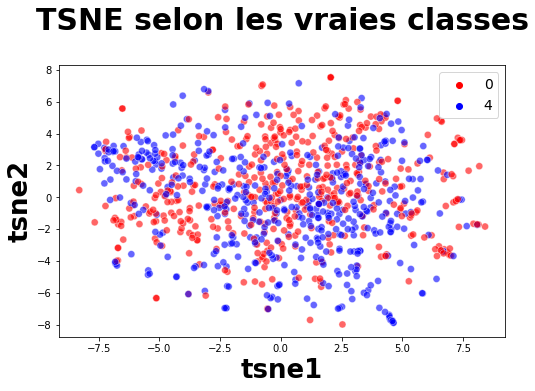

In [ ]:
plt.figure(figsize=(8,5))

palette={0:'red', 4:'blue'}
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=palette, s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

__Préliminaire pour l'entraînement des modèles :__ séparations des données d'entraînement et de test

In [ ]:
X = res_vect_comm
y = bad_buzz.target

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


$\color{ #549be2 }{\textbf{1er modèle : régression logistique}}$

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Entraîner le modèle
clf_ft = LogisticRegression()
clf_ft.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = clf_ft.predict(X_test)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.73


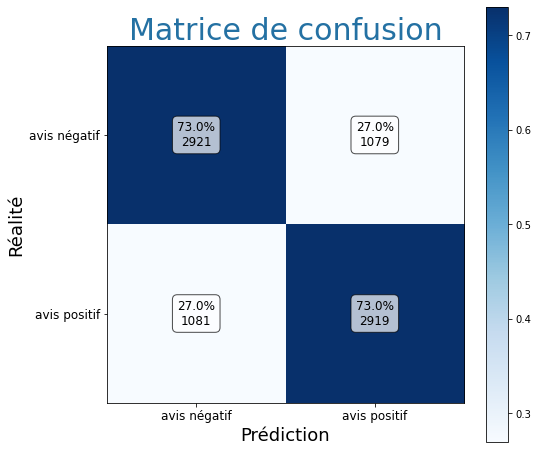

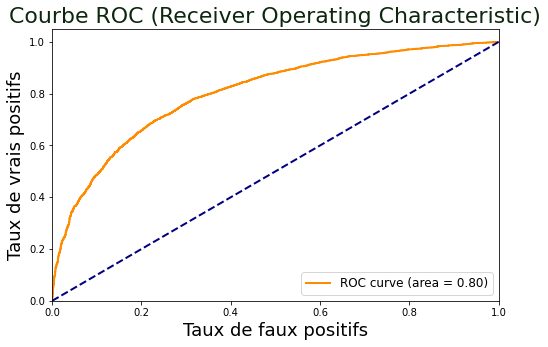

In [ ]:
evaluate_model(clf_ft, X_test, y_test)

$\color{#549be2}{\textbf{2ème modèle : Forêt aléatoire}}$

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de forêt aléatoire
rf_ft = RandomForestClassifier(n_estimators=150, max_depth=12, max_features="sqrt",
                            max_samples=0.6, random_state=42, n_jobs=8)
rf_ft.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = rf_ft.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7245


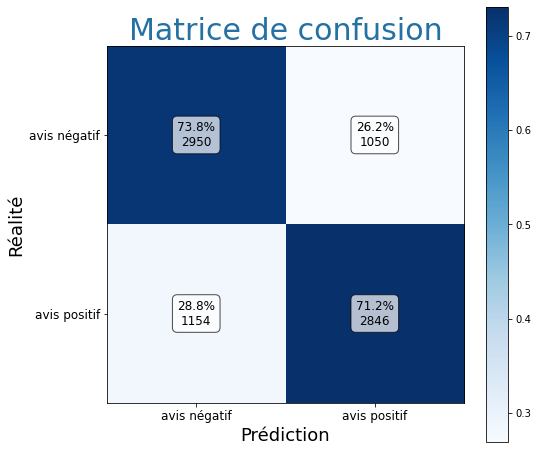

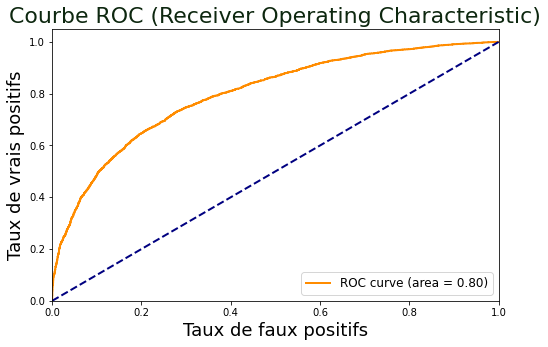

In [ ]:
evaluate_model(rf_ft, X_test, y_test)

$\color{#549be2}{\textbf{3ème modèle : Gradient boosting tree}}$

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Initialisation et entraînement du modèle de gradient boosting
gb_ft = GradientBoostingClassifier(n_estimators=250, subsample=0.5, max_features="sqrt",
                                max_depth=5, tol=5, random_state=42)
gb_ft.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = gb_ft.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.73625


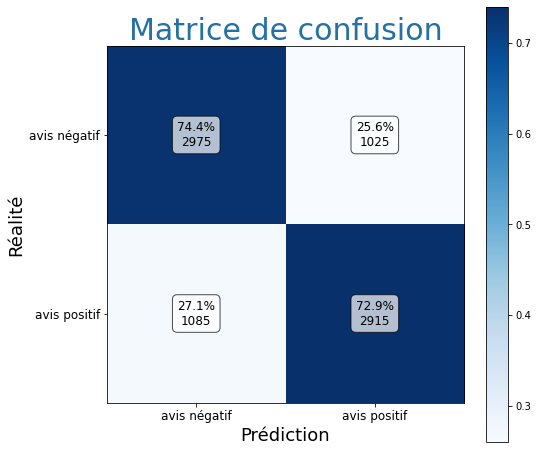

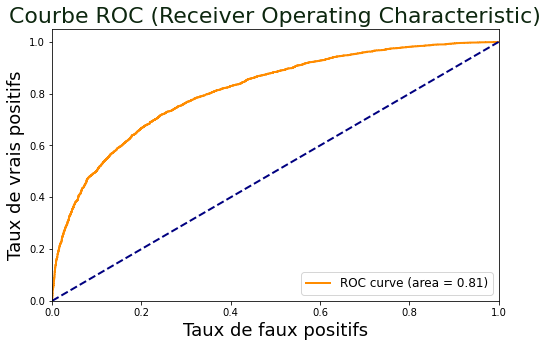

In [ ]:
evaluate_model(gb_ft, X_test, y_test)

$\color{#549be2}{\textbf{4ème modèle : Méthode d'ensemble avec combinaison des modèles précédents}}$

In [ ]:
%%time
from sklearn.ensemble import StackingClassifier

# Création du stacking classifier avec les 6 modèles entraînés
estimators = [('clf_ft', clf_ft), ('rf_ft', rf_ft), ('gb_ft', gb_ft), ('stacking_clf_d2v', stacking_clf_d2v)]
stacking_clf_ft = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Entraînement du modèle sur les données d'entraînement
stacking_clf_ft.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = stacking_clf_ft.predict(X_test)

# Évaluation des performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : ", accuracy)



Accuracy :  0.741625
CPU times: total: 22min 42s
Wall time: 24min 33s


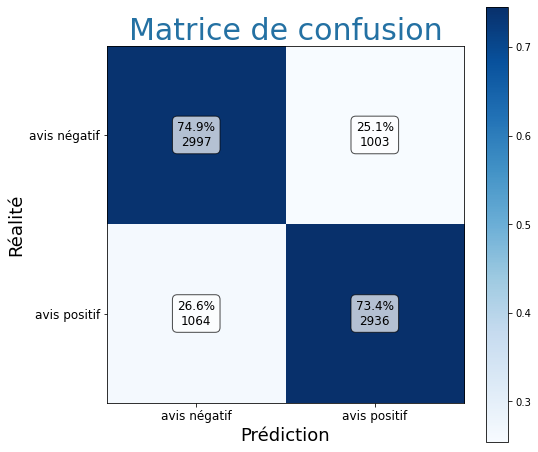

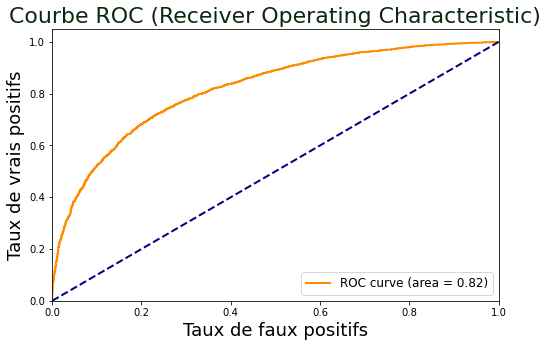

In [ ]:
evaluate_model(stacking_clf_ft, X_test, y_test)

Prédiction à l'aide d'un modèle de réseau de neurone

## 2.3 Modèle BERT <a class="anchor" id="partie2_3"></a>

BERT (Bidirectional Encoder Representations from Transformers) est un modèle de langage de pointe en traitement du langage naturel qui utilise une méthode d'apprentissage préalable supervisée pour capturer des informations contextuelles riches sur les mots.

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 64.5 MB/s eta 0:00:00


In [4]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.7 MB/s eta 0:00:00


In [5]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras
import pandas as pd

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
bad_buzz = pd.read_csv(r"./drive/MyDrive/P7/bad_buzz_ready4analysis.csv", sep="\t")

In [9]:
bad_buzz.head()

,target,text_clean
0,0,www that summer you should david care third day d
1,0,upset that he not update his facebook by testi...
2,0,dived many time ball managed save rest go out ...
3,0,whole body feel itchy like fire
4,0,no not behaving mad why here because not see y...


In [10]:
bad_buzz.target = bad_buzz["target"].replace({0: "negatif", 4: "positif"})
bad_buzz.head()

,target,text_clean
0,negatif,www that summer you should david care third day d
1,negatif,upset that he not update his facebook by testi...
2,negatif,dived many time ball managed save rest go out ...
3,negatif,whole body feel itchy like fire
4,negatif,no not behaving mad why here because not see y...


In [11]:
bad_buzz["label_pos"] = bad_buzz.target.apply(lambda x: 1 if x=='positif' else 0)
bad_buzz.sample(5)

,target,text_clean,label_pos
25034,negatif,lose follower like lose hair oh yeah there guy...,0
31514,positif,nick north s infinite playlist really cut,1
22371,negatif,long weekend became an extra short one working...,0
29743,negatif,hope you your six though,0
29273,negatif,really amazing wa going between from dig nice ...,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(bad_buzz['text_clean'], bad_buzz['label_pos'], stratify=bad_buzz['label_pos'])

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
text_input = tf.keras.layers.Input(batch_size=32, shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(32,)]              0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (32, 128),                                                        
                                 'input_mask': (32,                                               
                                 128),                                                            
                                 'input_type_ids':                                                
                                (32, 128)}                                                  

In [16]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=0.001, weight_decay=0.001)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)


In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
938/938 [==============================] - 325s 340ms/step - loss: 0.6615 - accuracy: 0.6024 - auc: 0.6420
Epoch 2/10
938/938 [==============================] - 315s 336ms/step - loss: 0.6145 - accuracy: 0.6664 - auc: 0.7263
Epoch 3/10
938/938 [==============================] - 321s 343ms/step - loss: 0.5997 - accuracy: 0.6783 - auc: 0.7437
Epoch 4/10
938/938 [==============================] - 316s 337ms/step - loss: 0.5883 - accuracy: 0.6897 - auc: 0.7565
Epoch 5/10
938/938 [==============================] - 316s 337ms/step - loss: 0.5822 - accuracy: 0.6927 - auc: 0.7620
Epoch 6/10
938/938 [==============================] - 315s 336ms/step - loss: 0.5793 - accuracy: 0.6954 - auc: 0.7651
Epoch 7/10
938/938 [==============================] - 316s 337ms/step - loss: 0.5724 - accuracy: 0.7024 - auc: 0.7720
Epoch 8/10
938/938 [==============================] - 315s 336ms/step - loss: 0.5742 - accuracy: 0.7019 - auc: 0.7704
Epoch 9/10
938/938 [==============================] - 31

In [ ]:
# Évaluer le modèle sur le jeu de données de test
loss, accuracy, auc = model.evaluate(X_test, y_test)

# Afficher la précision du modèle
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('AUC: {:.2f}%'.format(auc * 100))


313/313 [==============================] - 106s 333ms/step - loss: 0.5503 - accuracy: 0.7296 - auc: 0.8006
Accuracy: 72.96%
AUC: 80.06%


In [ ]:
model.save("./drive/MyDrive/P7/bert_class")

In [ ]:
# model = tf.keras.models.load_model("./drive/MyDrive/P7/bert_class")

__On va maintenant créer un modèle plus complexe avec deux couches denses supplémentaires en fin de modèle.__

Commençons par afficher les caractéristiques de ce nouveau modèle.

In [ ]:
# Définition de l'entrée du modèle
text_input = tf.keras.layers.Input(batch_size=32, shape=(), dtype=tf.string, name='text')

# Prétraitement puis codage du texte avec les fonctions bert_preprocess et bert_encoder
preprocessed_text = bert_preprocess(text_input)
encoded_text = bert_encoder(preprocessed_text)

# Extraction de la sortie "pooled_output" du modèle BERT
pooled_output = encoded_text['pooled_output']

# Ajout d'une couche Dropout pour régulariser le modèle
l = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
# Ajout de deux couches Denses avec des fonctions d'activation ReLU
l = tf.keras.layers.Dense(128, activation='relu', name="dense_1")(l)
l = tf.keras.layers.Dense(64, activation='relu', name="dense_2")(l)

# Ajout d'une couche Dense de sortie avec une fonction d'activation sigmoid
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(32,)]              0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (32,  0           ['text[0][0]']                   
                                 128),                                                            
                                 'input_word_ids':                                                
                                (32, 128),                                                        
                                 'input_type_ids':                                                
                                (32, 128)}                                                    

On constate qu'il y a __106 753__ paramètres à entraîner là où il y en avait __769__ pour le précédent modèle.

In [ ]:
%%time



# Définition des différentes valeurs pour les hyperparamètres à tester
learning_rates = [1e-5, 5e-5, 1e-4]
weight_decays = [0.001, 0.01, 0.1]
      
# Définition de l'entrée du modèle
text_input = tf.keras.layers.Input(batch_size=32, shape=(), dtype=tf.string, name='text')

# Prétraitement puis codage du texte avec les fonctions bert_preprocess et bert_encoder
preprocessed_text = bert_preprocess(text_input)
encoded_text = bert_encoder(preprocessed_text)

# Extraction de la sortie "pooled_output" du modèle BERT
pooled_output = encoded_text['pooled_output']

# Ajout d'une couche Dropout pour régulariser le modèle
l = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
# Ajout de deux couches Denses avec des fonctions d'activation ReLU
l = tf.keras.layers.Dense(128, activation='relu', name="dense_1")(l)
l = tf.keras.layers.Dense(64, activation='relu', name="dense_2")(l)

# Ajout d'une couche Dense de sortie avec une fonction d'activation sigmoid
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)


for lr in learning_rates:
    for wd in weight_decays:

      # Création d'un modèle Keras avec les entrées et sorties définies
      model = tf.keras.Model(inputs=[text_input], outputs=[output])
            
      # Définition de l'optimiseur AdamW avec le taux d'apprentissage 
      # et le taux de décroissance pondérée correspondant
      optimizer = AdamW(learning_rate=lr, weight_decay=wd)
      METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.AUC(name='auc')
          ]

      # Compilation du modèle avec la fonction de perte binaire 'binary_crossentropy' et l'optimiseur AdamW
      model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=METRICS)

      # Entraîner le modèle
      history = model.fit(
          X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10)

      # evaluate model on test data
      results = model.evaluate(X_test, y_test, batch_size=32)
      print("lr={}, wd={}: Test Accuracy: {:.2f}%".format(lr, wd, results[1] * 100))


Epoch 1/10
938/938 [==============================] - 478s 493ms/step - loss: 0.6950 - accuracy: 0.5113 - auc: 0.5160 - val_loss: 0.6859 - val_accuracy: 0.5831 - val_auc: 0.6173
Epoch 2/10
938/938 [==============================] - 460s 491ms/step - loss: 0.6840 - accuracy: 0.5603 - auc: 0.5854 - val_loss: 0.6757 - val_accuracy: 0.6118 - val_auc: 0.6770
Epoch 3/10
938/938 [==============================] - 460s 491ms/step - loss: 0.6743 - accuracy: 0.5917 - auc: 0.6278 - val_loss: 0.6658 - val_accuracy: 0.6421 - val_auc: 0.6940
Epoch 4/10
938/938 [==============================] - 460s 490ms/step - loss: 0.6658 - accuracy: 0.6097 - auc: 0.6521 - val_loss: 0.6568 - val_accuracy: 0.6511 - val_auc: 0.7033
Epoch 5/10
938/938 [==============================] - 460s 491ms/step - loss: 0.6581 - accuracy: 0.6181 - auc: 0.6667 - val_loss: 0.6484 - val_accuracy: 0.6565 - val_auc: 0.7115
Epoch 6/10
938/938 [==============================] - 460s 491ms/step - loss: 0.6509 - accuracy: 0.6308 - auc:

Le traitement s'étant arrêté en cours de route, on choisi de ne pas tout recommencer depuis le début puisqu'on a déjà certains résultats et que les calculs sont très chronophages. On va plutôt reprendre en ajustant les hyperparamètres à tester et diminuer le nombre d'epochs afin de gagner en temps de calcul.

In [18]:
%%time

# Définition des différentes valeurs pour les hyperparamètres à tester
learning_rates = [5e-5, 1e-4]
wd = 0.1
      
# Définition de l'entrée du modèle
text_input = tf.keras.layers.Input(batch_size=32, shape=(), dtype=tf.string, name='text')

# Prétraitement puis codage du texte avec les fonctions bert_preprocess et bert_encoder
preprocessed_text = bert_preprocess(text_input)
encoded_text = bert_encoder(preprocessed_text)

# Extraction de la sortie "pooled_output" du modèle BERT
pooled_output = encoded_text['pooled_output']

# Ajout d'une couche Dropout pour régulariser le modèle
l = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
# Ajout de deux couches Denses avec des fonctions d'activation ReLU
l = tf.keras.layers.Dense(128, activation='relu', name="dense_1")(l)
l = tf.keras.layers.Dense(64, activation='relu', name="dense_2")(l)

# Ajout d'une couche Dense de sortie avec une fonction d'activation sigmoid
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

results_dict = {}
for lr in learning_rates:

    # Création d'un modèle Keras avec les entrées et sorties définies
    model = tf.keras.Model(inputs=[text_input], outputs=[output])
          
    # Définition de l'optimiseur AdamW avec le taux d'apprentissage 
    # et le taux de décroissance pondérée correspondant
    optimizer = AdamW(learning_rate=lr, weight_decay=wd)
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc')
        ]

    # Compilation du modèle avec la fonction de perte binaire 'binary_crossentropy' et l'optimiseur AdamW
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=METRICS)

    # Entraîner le modèle
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=3)

    # evaluate model on test data
    results = model.evaluate(X_test, y_test, batch_size=32)
    results_dict[f"lr={lr}, wd={wd}"] = {"accuracy": results[1], "auc": results[2]}
    print("lr={}, wd={}: Test Accuracy: {:.2f}%".format(lr, wd, results[1] * 100))


Epoch 1/3
938/938 [==============================] - 468s 494ms/step - loss: 0.6745 - accuracy: 0.5797 - auc: 0.6126 - val_loss: 0.6508 - val_accuracy: 0.6145 - val_auc: 0.7039
Epoch 2/3
938/938 [==============================] - 462s 492ms/step - loss: 0.6399 - accuracy: 0.6375 - auc: 0.6894 - val_loss: 0.6187 - val_accuracy: 0.6760 - val_auc: 0.7408
Epoch 3/3
313/313 [==============================] - 105s 336ms/step - loss: 0.5927 - accuracy: 0.6953 - auc: 0.7645
lr=5e-05, wd=0.1: Test Accuracy: 69.53%
Epoch 1/3
938/938 [==============================] - 427s 452ms/step - loss: 0.6009 - accuracy: 0.6774 - auc: 0.7403 - val_loss: 0.5725 - val_accuracy: 0.7070 - val_auc: 0.7809
Epoch 2/3
938/938 [==============================] - 461s 491ms/step - loss: 0.5903 - accuracy: 0.6888 - auc: 0.7528 - val_loss: 0.5646 - val_accuracy: 0.7098 - val_auc: 0.7913
Epoch 3/3
313/313 [==============================] - 105s 337ms/step - loss: 0.5596 - accuracy: 0.7181 - auc: 0.7953
lr=0.0001, wd=0.1:

> Entraînement approfondi du meilleur modèle, puis enregistrement.

In [21]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

# Définition des différentes valeurs pour les hyperparamètres à tester
lr = 0.0001
wd = 0.1

# Définition de l'entrée du modèle
text_input = tf.keras.layers.Input(batch_size=32, shape=(), dtype=tf.string, name='text')

# Prétraitement puis codage du texte avec les fonctions bert_preprocess et bert_encoder
preprocessed_text = bert_preprocess(text_input)
encoded_text = bert_encoder(preprocessed_text)

# Extraction de la sortie "pooled_output" du modèle BERT
pooled_output = encoded_text['pooled_output']

# Ajout d'une couche Dropout pour régulariser le modèle
l = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
# Ajout de deux couches Denses avec des fonctions d'activation ReLU
l = tf.keras.layers.Dense(128, activation='relu', name="dense_1")(l)
l = tf.keras.layers.Dense(64, activation='relu', name="dense_2")(l)

# Ajout d'une couche Dense de sortie avec une fonction d'activation sigmoid
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)


# Création d'un modèle Keras avec les entrées et sorties définies
model = tf.keras.Model(inputs=[text_input], outputs=[output])
      
# Définition de l'optimiseur AdamW avec le taux d'apprentissage 
# et le taux de décroissance pondérée correspondant
optimizer = AdamW(learning_rate=lr, weight_decay=wd)
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc')
    ]

# rajout d'un paramètre afin de stopper l'apprentissage des poids, lorsque les résultats ne s'améliorent plus significativement.
early_stopping = EarlyStopping(
    monitor='val_accuracy', # Sur quelle métrique suivre les performances
    patience=2, # Nombre maximal d'epochs à effectuer après que la performance a cessé de s'améliorer
    verbose=1,
    restore_best_weights=True)

# Compilation du modèle avec la fonction de perte binaire 'binary_crossentropy' et l'optimiseur AdamW
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=12,
    callbacks=[early_stopping])

# evaluate model on test data
results = model.evaluate(X_test, y_test, batch_size=32)

print("lr={}, wd={}: Test Accuracy: {:.2f}%".format(lr, wd, results[1] * 100))


Epoch 1/12
938/938 [==============================] - 467s 493ms/step - loss: 0.6566 - accuracy: 0.6086 - auc: 0.6544 - val_loss: 0.6130 - val_accuracy: 0.6812 - val_auc: 0.7468
Epoch 2/12
938/938 [==============================] - 461s 492ms/step - loss: 0.6138 - accuracy: 0.6669 - auc: 0.7257 - val_loss: 0.5828 - val_accuracy: 0.7005 - val_auc: 0.7743
Epoch 3/12
938/938 [==============================] - 460s 491ms/step - loss: 0.5953 - accuracy: 0.6825 - auc: 0.7472 - val_loss: 0.5762 - val_accuracy: 0.7041 - val_auc: 0.7866
Epoch 4/12
938/938 [==============================] - 461s 492ms/step - loss: 0.5845 - accuracy: 0.6953 - auc: 0.7593 - val_loss: 0.5638 - val_accuracy: 0.7089 - val_auc: 0.7857
Epoch 5/12
938/938 [==============================] - 461s 491ms/step - loss: 0.5810 - accuracy: 0.6961 - auc: 0.7628 - val_loss: 0.5614 - val_accuracy: 0.7140 - val_auc: 0.7967
Epoch 6/12
938/938 [==============================] - 422s 450ms/step - loss: 0.5774 - accuracy: 0.6981 - auc:

In [22]:
model.save("./drive/MyDrive/P7/bert_class_up")